In [1]:
import sage

from itertools import combinations
import numpy as np
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/home/emmanuel-olateju/AIMS/XAI/AIMS.XAI.Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data and model

In [2]:
df = sage.datasets.bike()
features = df.columns.tolist()[:-3]
target = df.columns.tolist()[-1]

In [3]:
print("Features:", features)
print("Target:", target)

Features: ['Year', 'Month', 'Day', 'Hour', 'Season', 'Holiday', 'Workingday', 'Weather', 'Temp', 'Atemp', 'Humidity', 'Windspeed']
Target: Count


In [4]:
# Split data, with total count serving as regression target
train, test = train_test_split(df, test_size=int(0.1 * len(df.values)), random_state=123)
train, val = train_test_split(train, test_size=int(0.1 * len(df.values)), random_state=123)

y_train = train[[target]]
y_val = val[[target]]
y_test = test[[target]]
x_train = train[features]
x_val = val[features]
x_test = test[features]

In [5]:
model = xgboost.XGBRegressor()
model.fit(x_train, y_train);

In [6]:
def mse(prediction, target):
    return np.mean((prediction - target)**2).item()

In [7]:
# Calculate performance
base_mse = np.mean((np.mean(y_train) - y_test) ** 2)
full_mse = mse(model.predict(x_test), y_test.to_numpy().flatten())

print("Base rate MSE = {:.2f}".format(base_mse))
print("Model MSE = {:.2f}".format(full_mse))

Base rate MSE = 31591.23
Model MSE = 1878.77


## LOFO

Homework: Write the lofo function

In [45]:
def lofo(model, features, train_df, y_train, test_df, y_test, loss):
    losses = {}
    lofos_ratio = {}
    lofos_diff = {}

    for features_set in combinations(x_train.columns, len(x_train.columns)-1):# subset of features, removing one feature each time
        _excluded = list(set(x_train.columns) - set(features_set))[0]
        col = list(features_set)
        _x_train = train_df[col]
        _x_test = test_df[col]
    
        _model = xgboost.XGBRegressor()
        _model.fit(_x_train, y_train)

        #get the loss for the subset and store it
        y_pred = _model.predict(_x_test)
        _loss = loss(y_pred, y_test.to_numpy().flatten())
        losses[_excluded] = _loss

    for col in x_train.columns: # each feature in features,
        # calculate the lofo as a ratio or difference (or both)
        lofos_ratio[col] = losses[col] / full_mse
        lofos_diff[col] = losses[col] - full_mse

    return lofos_ratio, lofos_diff # the lofo(s)

In [ ]:
def lofo(model, features, train_df, y_train, test_df, y_test, loss):
    losses = {}
    lofos_ratio = {}
    lofos_diff = {}

    for _features in combinations(features, len(features)-1):
        _excluded = list(set(features) - set(_features))[0]
        _features = list(_features)
        _x_train = train_df[_features]
        _x_test = test_df[_features]
    
        _model = xgboost.XGBRegressor()
        _model.fit(_x_train, y_train)

        _loss = loss(_model.predict(_x_test), y_test.to_numpy().flatten())

        losses[_excluded] = _loss

    for _feature in features:
        lofos_ratio[_feature] = losses[_feature]/full_mse
        lofos_diff[_feature] = losses[_feature]-full_mse

    return lofos_ratio, lofos_diff

In [46]:
lofos_ratio, lofos_diff = lofo(model, features, train, y_train, test, y_test, mse)

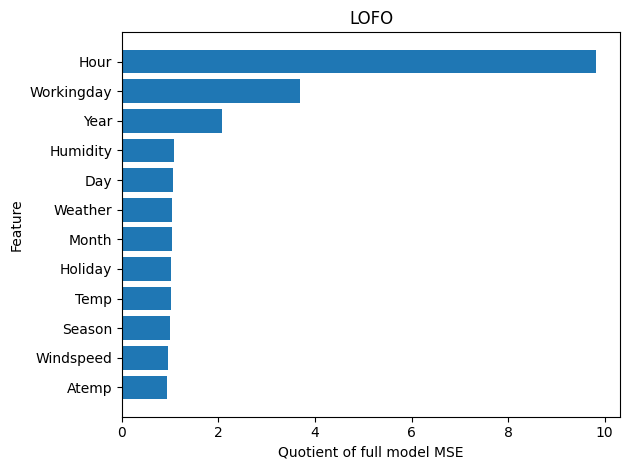

In [47]:
# Create horizontal bar plot from sorted values
sorted_items = sorted(lofos_ratio.items(), key=lambda x: x[1])
keys, values = zip(*sorted_items)

plt.barh(range(len(keys)), values)
plt.yticks(range(len(keys)), keys)
plt.xlabel('Quotient of full model MSE')
plt.ylabel('Feature')
plt.title('LOFO')
plt.tight_layout()
plt.show()

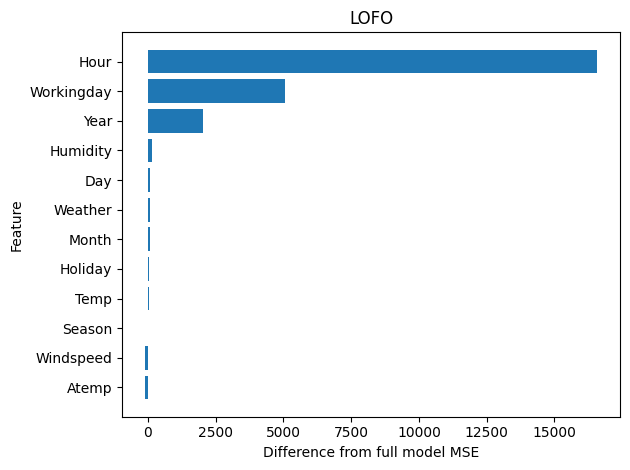

In [48]:
# Create horizontal bar plot from sorted values
sorted_items = sorted(lofos_diff.items(), key=lambda x: x[1])
keys, values = zip(*sorted_items)

plt.barh(range(len(keys)), values)
plt.yticks(range(len(keys)), keys)
plt.xlabel('Difference from full model MSE')
plt.ylabel('Feature')
plt.title('LOFO')
plt.tight_layout()
plt.show()